In [1]:
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random

from itertools import product
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from typing import Literal

from matplotlib import gridspec
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
import pickle 

from pscapes import ProteinLandscape

import json
import matplotlib.image as mpimg

In [2]:
models = ['linear', 'gb', 'rf', 'mlp', 'cnn', 'ulstm', 'blstm', 'transformer']

In [3]:
def hamming_dist(string_1, string_2):
    return sum(c1 != c2 for c1, c2 in zip(string_1, string_2))

def get_equidistant_points(radius, num_points, ):
    points = []
    for i in range(num_points):
        angle_degrees = (360 / num_points) * i 
        x = radius * math.cos(math.radians(angle_degrees))
        y = radius * math.sin(math.radians(angle_degrees))
        points.append((x, y))
    return points

def radial_plot(
        radius: int,
        regime: Literal['interpolation', 'extrapolation'],
        seed: int = 0, 
        extrapolation_index: int =5, 
        gray_out: list = [5], 
        seed_seq: str = 'ACDE', 
        alphabet: str = 'ACDEF'):
    
    # fix random seed
    np.random.seed(seed)

    # set sequences
    #seed_seq = "AAAAAA"
    #alphabet = "ABC"
    orig_seq_ls = [''.join(i) for i in product(alphabet, repeat = len(seed_seq))]
    seq_ls = []
    neighbourhood_ls = []
    for length in range(len(seed_seq) + 1):
        neighbours = []
        for seq in orig_seq_ls:
            if hamming_dist(seed_seq, seq) == length:
                neighbours.append(seq)
        # reduce neighbourhood so graph isnt ugly
        if len(neighbours) > 20:
            extra = neighbours[20:]
            to_remove = random.sample(extra, len(extra)//2)
            neighbours = neighbours[:20] + [x for x in extra if x not in to_remove]
        seq_ls += neighbours
        neighbourhood_ls.append(neighbours)

    # set test or train
    signal = []
    h_dist_list = []
    for seq in seq_ls:
        h_dist_list.append(hamming_dist(seed_seq, seq))
        if regime == "extrapolation":
            if gray_out != None: 
                
                if hamming_dist(seed_seq, seq) in gray_out:
                    signal.append(2)
                elif hamming_dist(seed_seq, seq) == extrapolation_index:
                    signal.append(1)
                else:
                    signal.append(0)
        elif regime == "interpolation":
            # i.e. 25 pct test split
            if gray_out!=None:
                if hamming_dist(seed_seq, seq) in gray_out:
                    signal.append(2)
                    
                elif np.random.random(1) > 0.75:
                    signal.append(1)
                else:
                    signal.append(0)

    # make adjacency matrix
    adjacency_matrix = np.zeros((len(seq_ls), len(seq_ls)), dtype="int8")
    for i in range(len(seq_ls)):
        for j in range(i):
            if j == i:
                continue
            elif hamming_dist(seq_ls[i], seq_ls[j]) == 1:
                adjacency_matrix[i][j] = 1
                adjacency_matrix[j][i] = 1

    # make graph
    graph = nx.from_numpy_array(adjacency_matrix)
    for idx, node in enumerate(graph.nodes()):
        graph.nodes[node]['seq'] = seq_ls[idx]
        graph.nodes[node]["signal"] = signal[idx]

    # make graph radial
    current_radius = 0
    position_dict = {}
    for neighbourhood in neighbourhood_ls:
        neighbourhood_positions = get_equidistant_points(
            current_radius,
            len(neighbourhood)
        )
        current_radius += radius
        for idx, sequence in enumerate(neighbourhood):
            position_dict[sequence] = neighbourhood_positions[idx]

    for node in graph.nodes():
        try:
            graph.nodes[node]["pos"] = position_dict[graph.nodes[node]["seq"]]
        except:
            pass
    return graph, h_dist_list

## Extrapolation

In [4]:
#load GB1 data 
with open('../results/extrapolation_results_GB1.pkl', 'rb') as file: 
    extrap_results_GB1 = pickle.load(file) 
pearson_results_GB1 = np.zeros((8, 4, 4, 4))  
mse_results_GB1 = np.zeros((8, 4, 4, 4))  
r2_results_GB1 = np.zeros((8, 4, 4, 4))  

In [5]:
# load GB1 data
for model_index, model in enumerate(models): 
    for repl_index, replicate in enumerate(extrap_results_GB1[model]['gb1'].keys()): 
        for train_index, train_distance in enumerate(extrap_results_GB1[model]['gb1'][replicate].keys()):
            for test_index, test_distance in enumerate(list(extrap_results_GB1[model]['gb1'][replicate][train_distance][0].keys())[1:]):
                pearson_results_GB1[model_index][repl_index][train_index][test_index] = extrap_results_GB1[model]['gb1'][replicate][train_distance][0][test_distance]['pearson_r']
                mse_results_GB1[model_index][repl_index][train_index][test_index] = extrap_results_GB1[model]['gb1'][replicate][train_distance][0][test_distance]['mse_loss']
                r2_results_GB1[model_index][repl_index][train_index][test_index] = extrap_results_GB1[model]['gb1'][replicate][train_distance][0][test_distance]['r2']
                    


In [6]:
pearson_results_gb1_mean = np.nanmean(pearson_results_GB1, axis=1)
mse_results_gb1_mean     = np.nanmean(mse_results_GB1, axis=1)
r2_results_gb1_mean      = np.nanmean(r2_results_GB1, axis=1)

In [7]:
def diagonal_mean(matrix): 
    assert matrix.ndim == 2 and matrix.shape[0] == matrix.shape[1], "Input must be a square matrix"
    n = matrix.shape[0]
    means = []
    stds  = []
    for k in range(1, n):  # Start from 1 to skip the main diagonal
        diag_elements = np.diag(matrix, k=k)  # Extract upper diagonal
        mean_value = np.mean(diag_elements) if len(diag_elements) > 0 else np.nan
        std_value  = np.std(diag_elements) if len(diag_elements) > 0 else np.nan
        means.append(mean_value)
        stds.append(std_value)
    return means


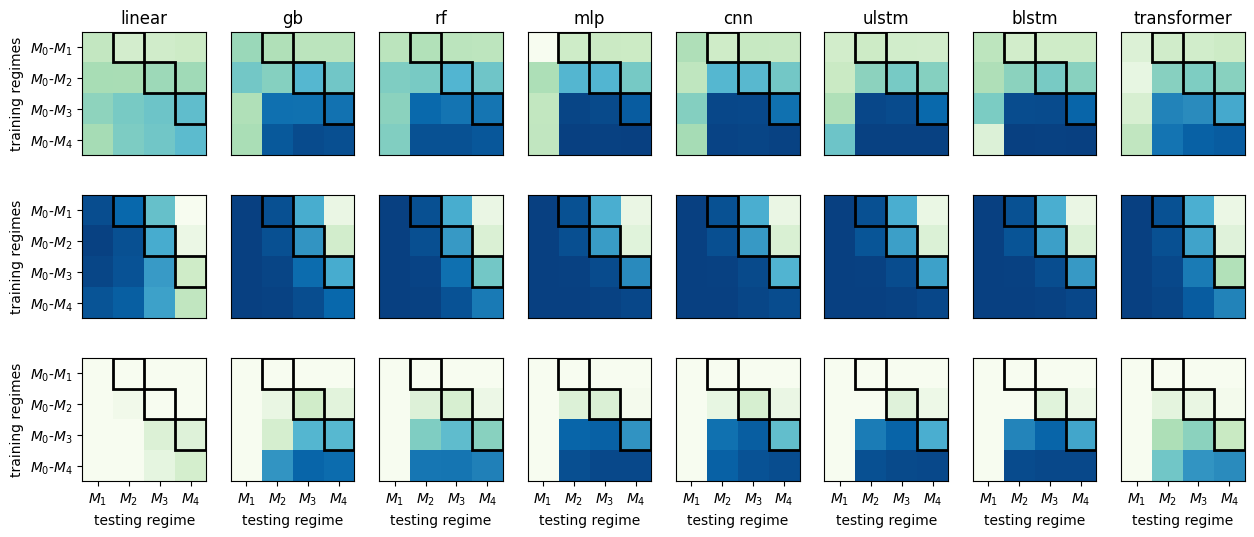

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=8, figsize=(15,6))

n=0
for rowi, row in enumerate(ax):
    for ind, axis in enumerate(row): 
        if n==0: 
            axis.imshow(pearson_results_gb1_mean[ind], 
                        cmap='GnBu', 
                        vmin=np.min(pearson_results_gb1_mean), 
                        vmax=np.max(pearson_results_gb1_mean))
        elif n==1: 
            axis.imshow(mse_results_gb1_mean[ind], 
                        cmap='GnBu_r', 
                        vmin=np.min(mse_results_gb1_mean), 
                        vmax=np.max(mse_results_gb1_mean))
        elif n==2: 
            axis.imshow(r2_results_gb1_mean[ind], 
                        cmap='GnBu', 
                        vmin=0, 
                        vmax=1)
        for val in range(3):   
            rect = Rectangle((val +0.5, val - 0.5), 1, 1, edgecolor="black", facecolor="none", linewidth=2)
            axis.add_patch(rect)

      
                        
            
    n+=1

for axis in ax[-1,:]: 
    axis.set_xticks(range(4))
    axis.set_xticklabels([f'$M_{i + 1}$' for i in range(4)], rotation=0, fontsize=10)
    axis.set_xlabel('testing regime')
for axis in np.ravel(ax[:-1,:]): 
    axis.set_xticks([])


for axis in np.ravel(ax[:,1:]):
    axis.set_yticks([])

for axis in ax[:,0]: 
    axis.set_yticks(range(4))
    axis.set_yticklabels([f'$M_{0}$-$M_{i + 1}$' for i in range(4)], rotation=0, fontsize=10)
    axis.set_ylabel('training regimes')

for ind, axis in enumerate(ax[0,:]):
    axis.set_title(models[ind])



In [9]:
pearson_results_gb1_mean_diags = np.array([diagonal_mean(model_result) for model_result in pearson_results_gb1_mean])
mse_results_gb1_mean_diags = np.array([diagonal_mean(model_result) for model_result in mse_results_gb1_mean])
r2_results_gb1_mean_diags = np.array([diagonal_mean(model_result) for model_result in r2_results_gb1_mean])

In [10]:
pearson_results_gb1_mean_diags

array([[ 0.20809384,  0.09991685,  0.01205015],
       [ 0.46889197,  0.23704396,  0.09436042],
       [ 0.46619199,  0.24370462,  0.0907742 ],
       [ 0.45304996,  0.1949071 ,  0.02097153],
       [ 0.41806084,  0.21070626,  0.04080884],
       [ 0.39930194,  0.14381697, -0.02839984],
       [ 0.38882639,  0.14547154, -0.00513149],
       [ 0.28646678,  0.13899145,  0.01609832]])

/tmp/ipykernel_4142/2786043884.py:24: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data=df,
/tmp/ipykernel_4142/2786043884.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models,
/tmp/ipykernel_4142/2786043884.py:24: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data=df,
/tmp/ipykernel_4142/2786043884.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models,
/tmp/ipykernel_4142/2786043884.py:24: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data=df,
/tmp/ipykernel_4142/2786043884.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or u

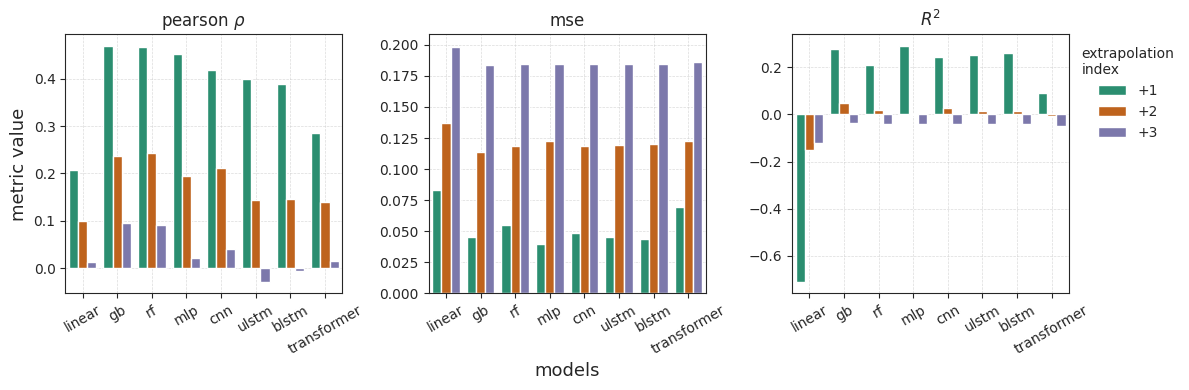

In [11]:
sns.set_style("ticks")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

titles = [r'pearson $\rho$', 'mse', r'$R^2$']

dark2_palette = sns.color_palette("Dark2", len(models)) 

results = [pearson_results_gb1_mean_diags.T, 
           mse_results_gb1_mean_diags.T, 
           r2_results_gb1_mean_diags.T]

for ind, ax in enumerate(axes):
    y = results[ind] 
    x = np.array(list(range(len(models))))
    width = 0.2 

    df = pd.DataFrame({
        'Model': np.tile(models, 3), 
        'Extrapolation': np.repeat(['+1', '+2', '+3'], len(models)), 
        'Value': np.concatenate([y[0], y[1], y[2]])
    })

    sns.barplot(data=df, 
                x='Model',
                y='Value', 
                hue='Extrapolation', 
                ax=ax, palette=dark2_palette)
    
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    ax.set_title(titles[ind])
    
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xticklabels(models, 
                      rotation=30, 
                      )
    ax.get_legend().set_visible(False)
    
    if ind==1: 
        ax.set_xlabel('models', fontsize=13)
    if ind==0: 
        ax.set_ylabel('metric value', fontsize=13)
    if ind==2:         
        ax.legend(title="extrapolation\nindex", bbox_to_anchor=(1, 1), loc="upper left", frameon=False)
fig.tight_layout()
#plt.savefig('../figures/extrapolation_indices_GB1.png')

In [16]:
gb1_landscape = ProteinLandscape(csv_path='../data/experimental_datasets/gb1.csv')
nk_landscape  = ProteinLandscape(csv_path='../data/nk_landscapes/k0_r0.csv')


        Protein Landscape class
            Number of Sequences : 149361
            Max Distance        : 4
            Number of Distances : 5
            Seed Sequence       : VDGV
                Modified positions are shown in green
            
        

        Protein Landscape class
            Number of Sequences : 46656
            Max Distance        : 6
            Number of Distances : 7
            Seed Sequence       : AAAAAA
                Modified positions are shown in green
            
        


In [17]:
dists_gb1 = [gb1_landscape.sklearn_data(distance=d)[0].shape[0] for d in range(5)]
dists_nk  = [nk_landscape.sklearn_data(distance=d)[0].shape[0] for d in range(7)]

#del gb1_landscape
#del nk_landscape

In [21]:
'EALV' in gb1_landscape.sequences

True

In [22]:
test = np.zeros((4,4))
for k in range(1, 4):  # Start from 1 to skip the main diagonal
        diag_elements = np.diag(test, k=k) 
        print (diag_elements  )  # Extract upper diagonal
        #mean_value = np.mean(diag_elements) if len(diag_elements) > 0 else np.nan
        #means.append(mean_value)

[0. 0. 0.]
[0. 0.]
[0.]


In [23]:
dists_gb1_prct = [(i/sum(dists_gb1))*100 for i in dists_gb1]
dists_nk_prct  = [(i/sum(dists_nk))*100 for i in dists_nk]

Text(0, 0.5, 'hamming distance from seed sequence')

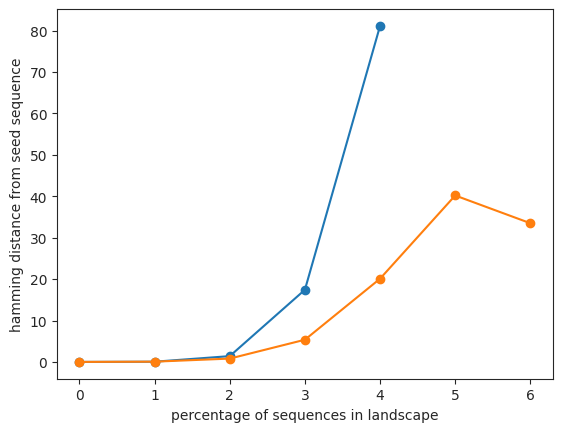

In [24]:
plt.plot(dists_gb1_prct, marker='o')
plt.plot(dists_nk_prct, marker='o')
plt.xlabel("percentage of sequences in landscape")
plt.ylabel("hamming distance from seed sequence")

## Ablation

In [25]:
models_nn = [i for i in models if i not in ['rf', 'gb']]

In [26]:
with open('../results/ablation_results_GB1.pkl', 'rb') as file: 
    abl_results_gb1 = pickle.load(file)

abl_pearson_results_gb1 = np.zeros((6,4,5))
abl_mse_results_gb1 = np.zeros((6,4,5))
abl_r2_results_gb1 = np.zeros((6,4,5))

for model_index, model in enumerate(models_nn): 
    for l_index, landscape in enumerate(abl_results_gb1[model].keys()):         
        for repl_index, replicate in enumerate(abl_results_gb1[model][landscape].keys()): 
            for density_ind, density in enumerate(abl_results_gb1[model][landscape][replicate].keys()): 
                abl_pearson_results_gb1[model_index][repl_index][density_ind] = abl_results_gb1[model][landscape][replicate][density][0]['test']['pearson_r']
                abl_mse_results_gb1[model_index][repl_index][density_ind] = abl_results_gb1[model][landscape][replicate][density][0]['test']['mse_loss']
                abl_r2_results_gb1[model_index][repl_index][density_ind] = abl_results_gb1[model][landscape][replicate][density][0]['test']['r2']
                
                

In [27]:
models_tree = ['gb', 'rf']

In [28]:
with open('../results/ablation_results_GB1_rf_gb.pkl', 'rb') as file: 
    abl_results_gb1_tree = pickle.load(file)

abl_pearson_results_gb1_tree = np.zeros((2,4,5))
abl_mse_results_gb1_tree = np.zeros((2,4,5))
abl_r2_results_gb1_tree = np.zeros((2,4,5))

for model_index, model in enumerate(models_tree): 
    for l_index, landscape in enumerate(abl_results_gb1_tree[model].keys()):         
        for repl_index, replicate in enumerate(abl_results_gb1_tree[model][landscape].keys()): 
            for density_ind, density in enumerate(abl_results_gb1_tree[model][landscape][replicate].keys()): 
                abl_pearson_results_gb1_tree[model_index][repl_index][density_ind] = abl_results_gb1_tree[model][landscape][replicate][density][0]['test']['pearson_r']
                abl_mse_results_gb1_tree[model_index][repl_index][density_ind] = abl_results_gb1_tree[model][landscape][replicate][density][0]['test']['mse_loss']
                abl_r2_results_gb1_tree[model_index][repl_index][density_ind] = abl_results_gb1_tree[model][landscape][replicate][density][0]['test']['r2']
                

In [29]:
abl_pearson_results_gb1_tree

array([[[0.9227018 , 0.91882085, 0.90896699, 0.88702864, 0.83299351],
        [0.9227018 , 0.91882085, 0.90896699, 0.88702864, 0.83299351],
        [0.9227018 , 0.91882085, 0.90896699, 0.88702864, 0.83299351],
        [0.9227018 , 0.91882085, 0.90896699, 0.88702864, 0.83299351]],

       [[0.8891623 , 0.88672584, 0.87761655, 0.867745  , 0.81938597],
        [0.8891623 , 0.88672584, 0.87761655, 0.867745  , 0.81938597],
        [0.8891623 , 0.88672584, 0.87761655, 0.867745  , 0.81938597],
        [0.8891623 , 0.88672584, 0.87761655, 0.867745  , 0.81938597]]])

In [30]:
abl_pearson_results_gb1_all = np.concatenate((abl_pearson_results_gb1, abl_pearson_results_gb1_tree))
abl_mse_results_gb1_all = np.concatenate((abl_mse_results_gb1, abl_mse_results_gb1_tree))
abl_r2_results_gb1_all = np.concatenate((abl_r2_results_gb1, abl_r2_results_gb1_tree))

In [31]:
abl_pearson_results_gb1_all_mean = np.mean(abl_pearson_results_gb1_all, axis=1)
abl_mse_results_gb1_all_mean = np.mean(abl_mse_results_gb1_all, axis=1)
abl_r2_results_gb1_all_mean = np.mean(abl_r2_results_gb1_all, axis=1)

In [32]:
models_ablation = models_nn+models_tree

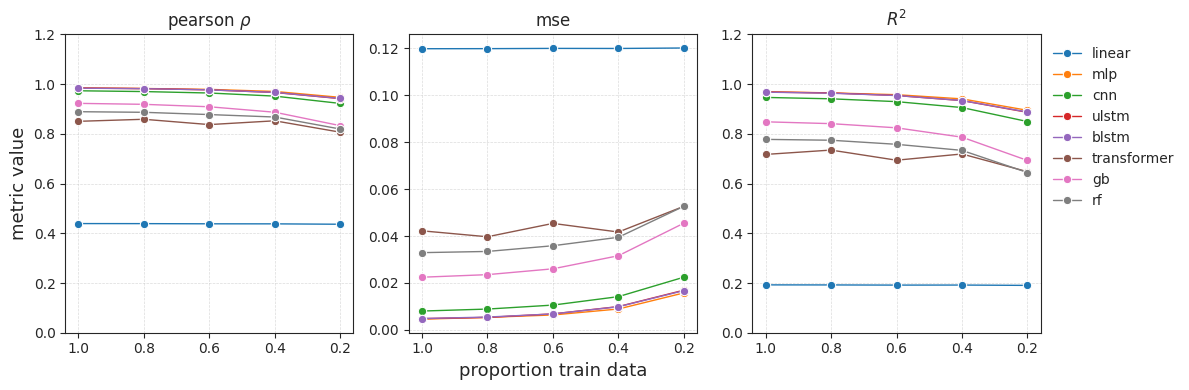

In [33]:
# Example data (replace with actual data)
sns.set_style("ticks")

ablation_labels = ['1.0', '0.8', '0.6', '0.4', '0.2']
results = [
    pd.DataFrame(abl_pearson_results_gb1_all_mean.T), 
    pd.DataFrame(abl_mse_results_gb1_all_mean.T), 
    pd.DataFrame(abl_r2_results_gb1_all_mean.T)
]

titles = [r'pearson $\rho$', 'mse', r'$R^2$']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for ind, ax in enumerate(axes):
    sns.lineplot(data=results[ind], 
                 marker='o', 
                 linewidth=1,
                 linestyle='-',
                 dashes=False,
                 ax=ax)
    ax.set_title(titles[ind])
    ax.set_xticks(range(len(ablation_labels)))
    ax.set_xticklabels(ablation_labels)
    if ind == 0 or ind == 2:
        ax.set_ylim(0, 1.2)
    ax.get_legend().set_visible(False)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    if ind==2:         
        handles, _ = ax.get_legend_handles_labels()
        ax.legend(handles, models_ablation, 
                  bbox_to_anchor=(1,1), 
                  loc='upper left', 
                  frameon=False)
    if ind==1: 
        ax.set_xlabel('proportion train data', fontsize=13)
    if ind==0: 
        ax.set_ylabel('metric value', fontsize=13)
fig.tight_layout()

In [40]:
models

['linear', 'gb', 'rf', 'mlp', 'cnn', 'ulstm', 'blstm', 'transformer']

## Figure 3


/tmp/ipykernel_4142/2328363439.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data=df,
/tmp/ipykernel_4142/2328363439.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(models,
/tmp/ipykernel_4142/2328363439.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


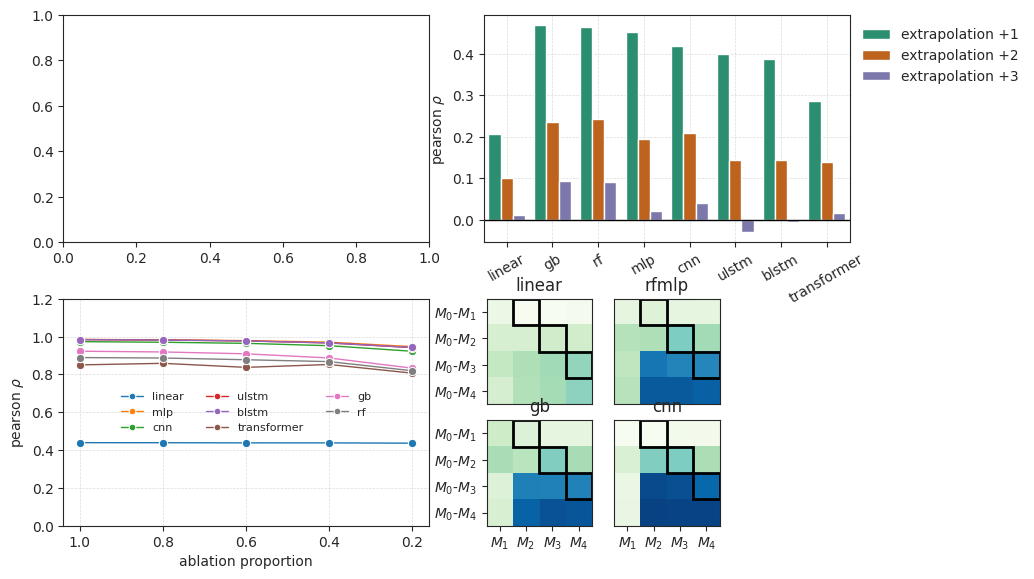

In [41]:

sns.set_style("ticks")
fig = plt.figure(figsize=(7*3, 7*2))

gs = gridspec.GridSpec(
    4, 4, figure=fig,
    wspace=0.15, 
    hspace=0.25
)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4_gs = gridspec.GridSpecFromSubplotSpec(2, 3, 
                                          subplot_spec=gs[1,1], 
                                         hspace=0.15, 
                                         wspace=0.15)
ax4_axes = np.array([[fig.add_subplot(ax4_gs[i, j]) for i in range(2)] for j in range(2) ])
#row_0_gs = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[0], wspace=01)



# AXIS 2 -- extrapolation results barplot#
y = pearson_results_gb1_mean_diags.T
df = pd.DataFrame({
        'Model': np.tile(models, 3), 
        'Extrapolation': np.repeat(['extrapolation +1', 'extrapolation +2', 'extrapolation +3'], len(models)), 
        'Value': np.concatenate([y[0], y[1], y[2]])
    })

sns.barplot(data=df, 
            x='Model',
            y='Value', 
            hue='Extrapolation', 
            ax=ax2, palette=dark2_palette)

ax2.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
ax2.axhline(0, color='black', linewidth=1) 

ax2.set_xticklabels(models, 
                  rotation=30, 
                  )
ax2.set_ylabel(r'pearson $\rho$')
ax2.set_xlabel('')
ax2.get_legend().set_visible(False)
ax2.legend(title="", bbox_to_anchor=(1, 1), loc="upper left", frameon=False)

# AXIS 3 -- ablation results lineplot#
ablation_labels = ['1.0', '0.8', '0.6', '0.4', '0.2']
data = pd.DataFrame(abl_pearson_results_gb1_all_mean.T)

sns.lineplot(data=data, 
                 marker='o', 
                 linewidth=1,
                 linestyle='-',
                 dashes=False,
                 ax=ax3)
ax3.get_legend().set_visible(False)
ax3.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
ax3.set_ylim(0,1.2)
handles, _ = ax3.get_legend_handles_labels()
ax3.legend(handles, 
           models_ablation, 
           ncol=3, 
           bbox_to_anchor=(0.5,0.5), 
           loc='center', 
           fontsize=8, 
           markerscale=0.8,
           frameon=False)
ax3.set_ylabel(r'pearson $\rho$')

ax3.set_xticks(range(len(ablation_labels)))
ax3.set_xticklabels(ablation_labels)
ax3.set_xlabel('ablation proportion')

# EXTRAPOLATION HEATMAPS ##

select_heatmap_models = ['linear', 'gb', 'rf' 'mlp', 'cnn', 'ulstm', ]

extrap_pearson_select_dsets = [pearson_results_gb1_mean[0],
                               pearson_results_gb1_mean[1],
                               pearson_results_gb1_mean[2],
                               pearson_results_gb1_mean[3], 
                               pearson_results_gb1_mean[4], 
                               pearson_results_gb1_mean[5]]


for ind, axis in enumerate(ax4_axes.flatten()): 
    axis.imshow(extrap_pearson_select_dsets[ind], 
                cmap='GnBu', 
                vmin=0, 
                vmax=1        
    )
    for val in range(3):   
            rect = Rectangle((val +0.5, val - 0.5), 1, 1, edgecolor="black", facecolor="none", linewidth=2)
            axis.add_patch(rect)
    axis.set_title(select_heatmap_models[ind])
    




for axis in ax4_axes.T[1,:]: 
    axis.set_xticks(range(4))
    axis.set_xticklabels([f'$M_{i + 1}$' for i in range(4)], rotation=0, fontsize=10)
    #axis.set_xlabel('testing regime')
    

for axis in np.ravel(ax4_axes.T[:-1,:]): 
    axis.set_xticks([])


for axis in np.ravel(ax4_axes.T[:,1:]):
    axis.set_yticks([])

for axis in ax4_axes.T[:,0]: 
    axis.set_yticks(range(4))
    axis.set_yticklabels([f'$M_{0}$-$M_{i + 1}$' for i in range(4)], rotation=0, fontsize=10)
    #axis.set_ylabel('training regimes')



#randd = np.random.rand(100,100)

#img = mpimg.imread("../figures/fig3_panelA.png")

#h, w, _ = img.shape  # Get height and width
#cropped_img = img[int(h*0.2):int(h*0.8), int(w*0.2):int(w*0.8)] 

#ax1.imshow(img)  
#ax1.axis("off")
fig.tight_layout()
plt.savefig('../figures/figure3_ALL.svg')
plt.savefig('../figures/figure3_ALL.png')

In [43]:
complementary_colors = [
    '#E67F83',  # Warm coral
    '#FFB367',  # Muted orange
    '#9F7AB0',  # Dusty purple

    '#7AA87F',  # Sage green
    '#CF8980',  # Rose
    '#6C8B98'   # Steel blue-gray
]

node_kwargs = {
    "cmap": ListedColormap(complementary_colors), # train and test colours
    "node_size": 40,
    "linewidths": 1,
    "edgecolors": "black",
}
edge_kwargs = {
    "edge_color": "#474747",
    "width": 1,
    "alpha": 0.1,
}


G_interp, hammings= radial_plot(radius=6,
                       regime="interpolation",
                       alphabet='ACDE', 
                       gray_out=[0,1,2,3,4]
                        )
pos_interp = nx.get_node_attributes(G_interp, 'pos')
signals_interp = np.array([G_interp.nodes[n]['signal'] for n in G_interp.nodes()])


In [44]:
signals_interp = [0 if ind==0 else i for ind, i in enumerate(signals_interp)]

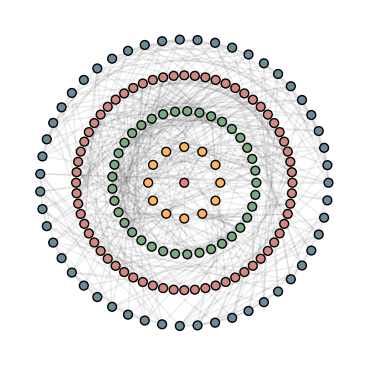

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5,4.5))
nx.draw_networkx_nodes(G_interp, 
                       pos=pos_interp, 
                       node_color=hammings, **node_kwargs)
nx.draw_networkx_edges(G_interp, pos=pos_interp, **edge_kwargs)
ax.axis("off")
plt.savefig('../figures/radial_plot_GB1.svg')